## Roofline analysis of transformer generation

In [142]:
from dataclasses import dataclass
from typing import Optional, Tuple

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [143]:
# References:
# https://www.nvidia.com/en-gb/data-center/products/a10-gpu/
# https://www.techpowerup.com/gpu-specs/a100-sxm4-40-gb.c3506

@dataclass
class XPU:
    name: str
    bytes_per_sec: int
    flop_per_sec: int
    capacity: float

# Numbers for fp16
a10 = XPU(name="A10", bytes_per_sec=600e9, flop_per_sec=125e12, capacity=24e9)
a100 = XPU(name="A100", bytes_per_sec=1560e9, flop_per_sec=312e12, capacity=40e9)

In [144]:
# Get FLOP count and memory transfer in bytes for attention during generation
def get_attn_perf_numbers(
    batch_size: int,
    seq_len: int,
    hidden_dim: int,
    kv_group_size: int,
    n_layers: int = 1,
    bytes_per_kv: float = 2,
) -> Tuple[int, int]:
    n_kv_elements = batch_size * n_layers * 2 * seq_len * hidden_dim // kv_group_size

    flops = 2 * n_kv_elements * kv_group_size
    memory_transfer = n_kv_elements * bytes_per_kv

    return flops, memory_transfer

In [145]:
# Get FLOP count and memory transfer in bytes for a single transformer generation step
def get_perf_numbers(
    batch_size: int,
    seq_len: int,
    hidden_dim: int,
    kv_group_size: int,
    n_layers: int = 1,
    bytes_per_param: float = 2,
    bytes_per_kv: float = 2,
    vocab_size: Optional[int] = None,
) -> Tuple[int, int]:
    if vocab_size is None:
        vocab_size = 0
    embed_params = hidden_dim * vocab_size
    model_params = n_layers * 12 * hidden_dim**2

    attn_flops, attn_mem = get_attn_perf_numbers(
        batch_size, seq_len, hidden_dim, kv_group_size, n_layers, bytes_per_kv
    )

    # Multiply + add per param, count output projection as well
    flops = 2 * batch_size * (model_params + embed_params) + attn_flops

    memory_transfer = (model_params + 2 * embed_params) * bytes_per_param + attn_mem

    return flops, memory_transfer

In [146]:
# Load measurements
df = pd.read_json("final_measurements.jsonl", lines=True)

In [147]:
def calc_mean_times(row):
    total_times = [x[0] for x in row.times]
    attn_times = [x[1] for x in row.times]
    return np.mean(total_times), np.mean(attn_times)

In [148]:
df[["time", "attn_time"]] = df.apply(lambda row: calc_mean_times(row), axis=1, result_type="expand")
df = df.drop("times", axis=1)

df[["flops", "memory_transfer"]] = df.apply(
    lambda row: get_perf_numbers(
        row.batch_size,
        row.seq_len,
        row.hidden_dim,
        row.kv_group_size,
        row.n_layers,
        row.bytes_per_param,
        row.bytes_per_kv,
        row.vocab_size,
    ),
    axis=1,
    result_type="expand",
)
df["arithmetic_intensity"] = df["flops"] / df["memory_transfer"]
df["flops_per_sec"] = df["flops"] / df["time"]

In [149]:
# Grab the rows to plot
df = df.iloc[[0, 4, 8]]
df

,model_name,batch_size,seq_len,bytes_per_param,bytes_per_kv,hidden_dim,kv_group_size,n_layers,vocab_size,error,device_name,time,attn_time,flops,memory_transfer,arithmetic_intensity,flops_per_sec
0,meta-llama/Llama-2-7b-hf,1,1,2,2,4096,1,32,32000,NaN,NVIDIA A100-SXM4-40GB,0.037196,0.005625,13147570176,13409714176,0.980451,3.534703e+11
4,meta-llama/Llama-2-7b-hf,1,23000,2,2,4096,1,32,32000,NaN,NVIDIA A100-SXM4-40GB,0.211888,0.017773,25205669888,25467813888,0.989707,1.189576e+11
8,meta-llama/Llama-2-7b-hf,20,1000,2,2,4096,1,32,32000,NaN,NVIDIA A100-SXM4-40GB,0.083249,0.014092,273426677760,23894949888,11.442865,3.284459e+12


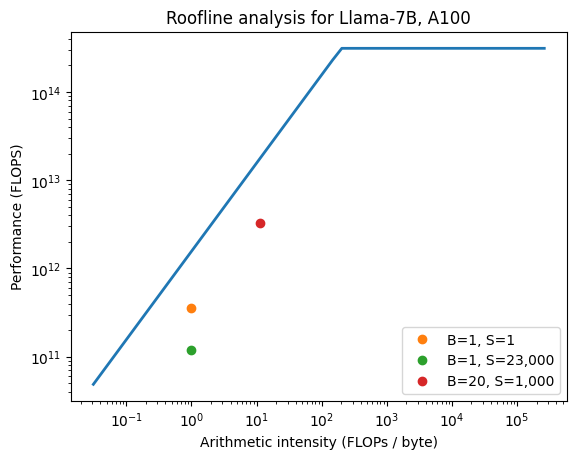

In [150]:
# Plot the basic roofline plot
platform = a100

# Arithmetic intensity
ai = np.logspace(-5, 18, base=2)
flops = np.minimum(ai * platform.bytes_per_sec, platform.flop_per_sec)

# Plot the platform roofline plot
plt.figure()
plt.plot(ai, flops, linewidth=2)
plt.xscale("log", base=10)
plt.yscale("log", base=10)
plt.xlabel("Arithmetic intensity (FLOPs / byte)")
plt.ylabel("Performance (FLOPS)")
plt.title(f"Roofline analysis for Llama-7B, {platform.name}")

# Plot specific points
for _, row in df.iterrows():
    plt.plot(row.arithmetic_intensity, row.flops_per_sec, 'o', label=f"B={row.batch_size}, S={row.seq_len:,}")

plt.legend(loc="lower right")
plt.show()

## Generation latency breakdown

For different setups, show the proportion of time spent doing the attention operation vs other parts of the model.

In [151]:
batch_size = 1
seq_len = 20_000

# Llama model config
kv_group_size = 1
hidden_dim = 4096
n_layers = 32
bytes_per_param = 2
bytes_per_kv = 2
vocab_size = 32_000

platform = a100

In [152]:
for seq_len in [1024, 23_000, 128_000]:
    attn_flops, attn_mem = get_attn_perf_numbers(
        batch_size, seq_len, hidden_dim, kv_group_size, n_layers, bytes_per_kv
    )
    flops, mem = get_perf_numbers(
        batch_size,
        seq_len,
        hidden_dim,
        kv_group_size,
        n_layers,
        bytes_per_param,
        bytes_per_kv,
        vocab_size,
    )
    print(f"Sequence length: {seq_len}")
    print(f"Total memory used in GB: {mem / 1e9}")
    
    attn_time = attn_flops / platform.flop_per_sec + attn_mem / platform.bytes_per_sec
    total_time = flops / platform.flop_per_sec + mem / platform.bytes_per_sec
    print(f"Attention time: {attn_time}, Total time: {total_time}, Ratio: {attn_time / total_time}\n\n")

Sequence length: 1024
Total memory used in GB: 13.9460608
Attention time: 0.00034586876061538463, Total time: 0.008983641271794872, Ratio: 0.038499841005592866


Sequence length: 23000
Total memory used in GB: 25.467813888
Attention time: 0.007768536615384616, Total time: 0.016406309126564104, Ratio: 0.47350909674170844


Sequence length: 128000
Total memory used in GB: 80.518053888
Attention time: 0.04323359507692308, Total time: 0.05187136758810257, Ratio: 0.8334770623406373




In [153]:
batch_size = 16
seq_len = 8192
attn_flops, attn_mem = get_attn_perf_numbers(
    batch_size, seq_len, hidden_dim, kv_group_size, n_layers, bytes_per_kv
)
flops, mem = get_perf_numbers(
    batch_size,
    seq_len,
    hidden_dim,
    kv_group_size,
    n_layers,
    bytes_per_param,
    bytes_per_kv,
    vocab_size,
)
print(f"Sequence length: {seq_len}")
print(f"Total memory used in GB: {mem / 1e9}")

attn_time = attn_flops / platform.flop_per_sec + attn_mem / platform.bytes_per_sec
total_time = flops / platform.flop_per_sec + mem / platform.bytes_per_sec
print(f"Attention time: {attn_time}, Total time: {total_time}, Ratio: {attn_time / total_time}")

Sequence length: 8192
Total memory used in GB: 82.128666624
Attention time: 0.04427120135876923, Total time: 0.05354104338379487, Ratio: 0.826864748253462
